In [1]:
!nvidia-smi

Fri Mar  1 09:55:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   34C    P8              20W / 215W |    694MiB /  8192MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
sr = 16000
data_dir = '../data/data_preprocessed/msp_podcast/features_4balanced/'
data_x = np.load(f'{data_dir}msp_podcast.audio16k.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}msp_podcast.label_emotion.npy', allow_pickle=True)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 11092
Test: 2774


In [8]:
y_train[0]

'ang'

In [10]:
np.unique(y_train)

array(['anger', 'happiness', 'neutral', 'sadness'], dtype='<U9')

In [12]:
labels = ['ang', 'neu', 'sad', 'hap']

In [13]:
def label_to_index(word):
    return labels.index(word[:3])
label_to_index(y_train[0])

1

In [14]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [17]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=4, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = [waveform[offset: length-offset]]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float).squeeze(), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label_to_index(label), 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [18]:
import traceback

In [19]:
from IConNet.nn.model import M13mfcc as M13
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m13mfcc.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M13mfcc', 'description': 'FirConv with fftconv', 'mfcc': {'n_mfcc': 40, 'n_fft': 512, 'hop_length': 128, 'n_mels': 64, 'sample_rate': 16000}, 'pooling': 'mean', 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


M13mfcc(
  (mfcc): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=40, out_features=512, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [20]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [21]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [22]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                | 0.0023094688221709007/10 [00:00<35:11, 211.16s/it]

Train Epoch: 1 [0/11092 (0%)]	Loss: 1.578089
Mem before-during-after: 1226752 9887232 21712384


  0%|▏                                 | 0.04849884526558889/10 [00:07<25:37, 154.51s/it]

Train Epoch: 1 [640/11092 (6%)]	Loss: 1.196749
Mem before-during-after: 21712384 21852160 21712384


  1%|▎                                 | 0.09468822170900681/10 [00:14<24:29, 148.36s/it]

Train Epoch: 1 [1280/11092 (12%)]	Loss: 1.660291
Mem before-during-after: 21712384 21852160 21712384


  1%|▍                                 | 0.14087759815242493/10 [00:21<24:28, 148.96s/it]

Train Epoch: 1 [1920/11092 (17%)]	Loss: 1.253682
Mem before-during-after: 21712384 21852160 21712384


  2%|▋                                  | 0.1870669745958434/10 [00:28<24:07, 147.48s/it]

Train Epoch: 1 [2560/11092 (23%)]	Loss: 1.235597
Mem before-during-after: 21712384 21852160 21712384


  2%|▊                                 | 0.23325635103926187/10 [00:35<24:47, 152.28s/it]

Train Epoch: 1 [3200/11092 (29%)]	Loss: 1.169391
Mem before-during-after: 21712384 21852160 21712384


  3%|▉                                 | 0.27944572748267965/10 [00:42<23:27, 144.80s/it]

Train Epoch: 1 [3840/11092 (35%)]	Loss: 1.316562
Mem before-during-after: 21712384 21852160 21712384


  3%|█▏                                  | 0.325635103926097/10 [00:49<23:42, 147.08s/it]

Train Epoch: 1 [4480/11092 (40%)]	Loss: 0.995629
Mem before-during-after: 21712384 21852160 21712384


  4%|█▎                                 | 0.3718244803695144/10 [00:56<23:30, 146.49s/it]

Train Epoch: 1 [5120/11092 (46%)]	Loss: 1.680741
Mem before-during-after: 21712384 21852160 21712384


  4%|█▍                                | 0.41801385681293174/10 [01:03<23:39, 148.13s/it]

Train Epoch: 1 [5760/11092 (52%)]	Loss: 1.234207
Mem before-during-after: 21712384 21852160 21712384


  5%|█▌                                 | 0.4642032332563491/10 [01:10<25:06, 158.01s/it]

Train Epoch: 1 [6400/11092 (58%)]	Loss: 1.176225
Mem before-during-after: 21712384 21852160 21712384


  5%|█▊                                  | 0.510392609699767/10 [01:17<23:40, 149.70s/it]

Train Epoch: 1 [7040/11092 (63%)]	Loss: 1.262355
Mem before-during-after: 21712384 21852160 21712384


  6%|█▉                                 | 0.5565819861431865/10 [01:24<24:04, 152.98s/it]

Train Epoch: 1 [7680/11092 (69%)]	Loss: 1.273780
Mem before-during-after: 21712384 21852160 21712384


  6%|██                                 | 0.6027713625866061/10 [01:31<23:34, 150.52s/it]

Train Epoch: 1 [8320/11092 (75%)]	Loss: 1.422088
Mem before-during-after: 21712384 21852160 21712384


  6%|██▎                                | 0.6489607390300257/10 [01:38<23:07, 148.35s/it]

Train Epoch: 1 [8960/11092 (81%)]	Loss: 1.238815
Mem before-during-after: 21712384 21852160 21712384


  7%|██▍                                | 0.6951501154734453/10 [01:45<23:29, 151.47s/it]

Train Epoch: 1 [9600/11092 (87%)]	Loss: 1.038368
Mem before-during-after: 21712384 21852160 21712384


  7%|██▌                                | 0.7401847575057794/10 [01:52<23:56, 155.09s/it]

Train Epoch: 1 [10240/11092 (92%)]	Loss: 0.942844
Mem before-during-after: 21712384 21852160 21712384


  8%|██▊                                 | 0.786374133949199/10 [01:59<22:44, 148.04s/it]

Train Epoch: 1 [10880/11092 (98%)]	Loss: 1.326571
Mem before-during-after: 21712384 21852160 21712384


 10%|███▌                               | 1.0011547344110998/10 [02:30<22:27, 149.73s/it]


Test Epoch: 1	Accuracy: 1316/2768 (47%)

Train Epoch: 2 [0/11092 (0%)]	Loss: 1.176242
Mem before-during-after: 21711360 21852160 21712384


 10%|███▋                               | 1.0484988452656003/10 [02:37<21:56, 147.09s/it]

Train Epoch: 2 [640/11092 (6%)]	Loss: 1.090240
Mem before-during-after: 21712384 21852160 21712384


 11%|███▊                               | 1.0946882217090155/10 [02:44<21:58, 148.07s/it]

Train Epoch: 2 [1280/11092 (12%)]	Loss: 1.068361
Mem before-during-after: 21712384 21852160 21712384


 11%|███▉                               | 1.1408775981524306/10 [02:51<22:24, 151.75s/it]

Train Epoch: 2 [1920/11092 (17%)]	Loss: 1.093284
Mem before-during-after: 21712384 21852160 21712384


 12%|████▏                              | 1.1870669745958458/10 [02:58<22:00, 149.86s/it]

Train Epoch: 2 [2560/11092 (23%)]	Loss: 0.806973
Mem before-during-after: 21712384 21852160 21712384


 12%|████▍                               | 1.233256351039261/10 [03:05<21:45, 148.86s/it]

Train Epoch: 2 [3200/11092 (29%)]	Loss: 1.086544
Mem before-during-after: 21712384 21852160 21712384


 13%|████▌                               | 1.279445727482676/10 [03:12<22:40, 156.00s/it]

Train Epoch: 2 [3840/11092 (35%)]	Loss: 1.094695
Mem before-during-after: 21712384 21852160 21712384


 13%|████▋                              | 1.3256351039260912/10 [03:19<21:18, 147.41s/it]

Train Epoch: 2 [4480/11092 (40%)]	Loss: 1.270298
Mem before-during-after: 21712384 21852160 21712384


 14%|████▊                              | 1.3718244803695063/10 [03:26<21:35, 150.17s/it]

Train Epoch: 2 [5120/11092 (46%)]	Loss: 1.208670
Mem before-during-after: 21712384 21852160 21712384


 14%|████▉                              | 1.4180138568129215/10 [03:33<21:17, 148.84s/it]

Train Epoch: 2 [5760/11092 (52%)]	Loss: 0.916043
Mem before-during-after: 21712384 21852160 21712384


 15%|█████                              | 1.4642032332563366/10 [03:40<21:06, 148.35s/it]

Train Epoch: 2 [6400/11092 (58%)]	Loss: 1.174070
Mem before-during-after: 21712384 21852160 21712384


 15%|█████▎                             | 1.5103926096997518/10 [03:47<21:03, 148.87s/it]

Train Epoch: 2 [7040/11092 (63%)]	Loss: 0.914202
Mem before-during-after: 21712384 21852160 21712384


 16%|█████▌                              | 1.556581986143167/10 [03:54<21:55, 155.80s/it]

Train Epoch: 2 [7680/11092 (69%)]	Loss: 1.178667
Mem before-during-after: 21712384 21852160 21712384


 16%|█████▊                              | 1.602771362586582/10 [04:01<20:57, 149.77s/it]

Train Epoch: 2 [8320/11092 (75%)]	Loss: 1.678817
Mem before-during-after: 21712384 21852160 21712384


 16%|█████▊                             | 1.6489607390299972/10 [04:08<21:09, 152.00s/it]

Train Epoch: 2 [8960/11092 (81%)]	Loss: 1.303959
Mem before-during-after: 21712384 21852160 21712384


 17%|█████▉                             | 1.6951501154734123/10 [04:15<20:01, 144.66s/it]

Train Epoch: 2 [9600/11092 (87%)]	Loss: 1.258935
Mem before-during-after: 21712384 21852160 21712384


 17%|██████                             | 1.7413394919168275/10 [04:22<20:28, 148.74s/it]

Train Epoch: 2 [10240/11092 (92%)]	Loss: 1.038812
Mem before-during-after: 21712384 21852160 21712384


 18%|██████▎                            | 1.7875288683602426/10 [04:29<20:13, 147.79s/it]

Train Epoch: 2 [10880/11092 (98%)]	Loss: 1.274372
Mem before-during-after: 21712384 21852160 21712384


 20%|███████▏                            | 2.001154734411038/10 [05:01<20:08, 151.07s/it]


Test Epoch: 2	Accuracy: 1412/2768 (51%)

Train Epoch: 3 [0/11092 (0%)]	Loss: 1.006190
Mem before-during-after: 21711360 21852160 21712384


 20%|███████▏                           | 2.0484988452655384/10 [05:08<19:28, 146.93s/it]

Train Epoch: 3 [640/11092 (6%)]	Loss: 1.259913
Mem before-during-after: 21712384 21852160 21712384


 21%|███████▎                           | 2.0946882217089535/10 [05:15<19:20, 146.83s/it]

Train Epoch: 3 [1280/11092 (12%)]	Loss: 1.115950
Mem before-during-after: 21712384 21852160 21712384


 21%|███████▍                           | 2.1408775981523687/10 [05:22<19:44, 150.75s/it]

Train Epoch: 3 [1920/11092 (17%)]	Loss: 1.236320
Mem before-during-after: 21712384 21852160 21712384


 22%|███████▊                            | 2.187066974595784/10 [05:29<19:39, 150.92s/it]

Train Epoch: 3 [2560/11092 (23%)]	Loss: 1.040712
Mem before-during-after: 21712384 21852160 21712384


 22%|████████                            | 2.233256351039199/10 [05:36<19:38, 151.69s/it]

Train Epoch: 3 [3200/11092 (29%)]	Loss: 1.237975
Mem before-during-after: 21712384 21852160 21712384


 23%|████████▏                           | 2.279445727482614/10 [05:43<20:19, 157.99s/it]

Train Epoch: 3 [3840/11092 (35%)]	Loss: 1.180586
Mem before-during-after: 21712384 21852160 21712384


 23%|████████▏                          | 2.3256351039260292/10 [05:50<19:01, 148.78s/it]

Train Epoch: 3 [4480/11092 (40%)]	Loss: 1.622214
Mem before-during-after: 21712384 21852160 21712384


 24%|████████▎                          | 2.3718244803694444/10 [05:57<19:44, 155.27s/it]

Train Epoch: 3 [5120/11092 (46%)]	Loss: 1.353977
Mem before-during-after: 21712384 21852160 21712384


 24%|████████▍                          | 2.4180138568128595/10 [06:04<18:43, 148.17s/it]

Train Epoch: 3 [5760/11092 (52%)]	Loss: 1.102082
Mem before-during-after: 21712384 21852160 21712384


 25%|████████▌                          | 2.4642032332562747/10 [06:11<18:14, 145.28s/it]

Train Epoch: 3 [6400/11092 (58%)]	Loss: 0.945293
Mem before-during-after: 21712384 21852160 21712384


 25%|█████████▎                           | 2.51039260969969/10 [06:19<18:54, 151.52s/it]

Train Epoch: 3 [7040/11092 (63%)]	Loss: 1.051409
Mem before-during-after: 21712384 21852160 21712384


 26%|█████████▏                          | 2.556581986143105/10 [06:26<18:54, 152.36s/it]

Train Epoch: 3 [7680/11092 (69%)]	Loss: 1.274641
Mem before-during-after: 21712384 21852160 21712384


 26%|█████████▋                           | 2.60277136258652/10 [06:33<19:28, 157.96s/it]

Train Epoch: 3 [8320/11092 (75%)]	Loss: 1.331835
Mem before-during-after: 21712384 21852160 21712384


 26%|█████████▎                         | 2.6489607390299352/10 [06:40<18:37, 151.95s/it]

Train Epoch: 3 [8960/11092 (81%)]	Loss: 1.160882
Mem before-during-after: 21712384 21852160 21712384


 27%|█████████▍                         | 2.6951501154733504/10 [06:47<18:26, 151.44s/it]

Train Epoch: 3 [9600/11092 (87%)]	Loss: 1.025762
Mem before-during-after: 21712384 21852160 21712384


 27%|█████████▌                         | 2.7413394919167655/10 [06:53<17:51, 147.65s/it]

Train Epoch: 3 [10240/11092 (92%)]	Loss: 1.062797
Mem before-during-after: 21712384 21852160 21712384


 28%|█████████▊                         | 2.7875288683601807/10 [07:00<18:05, 150.55s/it]

Train Epoch: 3 [10880/11092 (98%)]	Loss: 1.215636
Mem before-during-after: 21712384 21852160 21712384


 30%|██████████▍                        | 2.9999999999998903/10 [07:32<17:08, 146.98s/it]


Test Epoch: 3	Accuracy: 1378/2768 (50%)



 30%|██████████▊                         | 3.002309468822061/10 [07:33<18:06, 155.20s/it]

Train Epoch: 4 [0/11092 (0%)]	Loss: 1.264553
Mem before-during-after: 21711360 21852160 21712384


 30%|██████████▉                         | 3.048498845265476/10 [07:39<16:52, 145.68s/it]

Train Epoch: 4 [640/11092 (6%)]	Loss: 1.088853
Mem before-during-after: 21712384 21852160 21712384


 31%|██████████▊                        | 3.0946882217088914/10 [07:46<17:08, 148.89s/it]

Train Epoch: 4 [1280/11092 (12%)]	Loss: 1.360160
Mem before-during-after: 21712384 21852160 21712384


 31%|██████████▉                        | 3.1408775981523065/10 [07:53<17:13, 150.74s/it]

Train Epoch: 4 [1920/11092 (17%)]	Loss: 0.802601
Mem before-during-after: 21712384 21852160 21712384


 32%|███████████▏                       | 3.1870669745957216/10 [08:00<16:30, 145.35s/it]

Train Epoch: 4 [2560/11092 (23%)]	Loss: 1.519784
Mem before-during-after: 21712384 21852160 21712384


 32%|███████████▎                       | 3.2321016166280514/10 [08:07<16:37, 147.41s/it]

Train Epoch: 4 [3200/11092 (29%)]	Loss: 1.499906
Mem before-during-after: 21712384 21852160 21712384


 33%|███████████▊                        | 3.279445727482552/10 [08:14<16:08, 144.05s/it]

Train Epoch: 4 [3840/11092 (35%)]	Loss: 0.927108
Mem before-during-after: 21712384 21852160 21712384


 33%|███████████▉                        | 3.325635103925967/10 [08:21<16:06, 144.85s/it]

Train Epoch: 4 [4480/11092 (40%)]	Loss: 1.274580
Mem before-during-after: 21712384 21852160 21712384


 34%|████████████▏                       | 3.371824480369382/10 [08:28<16:15, 147.16s/it]

Train Epoch: 4 [5120/11092 (46%)]	Loss: 0.973618
Mem before-during-after: 21712384 21852160 21712384


 34%|███████████▉                       | 3.4180138568127973/10 [08:35<16:09, 147.29s/it]

Train Epoch: 4 [5760/11092 (52%)]	Loss: 0.937417
Mem before-during-after: 21712384 21852160 21712384


 35%|████████████                       | 3.4642032332562125/10 [08:42<15:55, 146.18s/it]

Train Epoch: 4 [6400/11092 (58%)]	Loss: 1.331755
Mem before-during-after: 21712384 21852160 21712384


 35%|████████████▎                      | 3.5103926096996276/10 [08:49<15:52, 146.73s/it]

Train Epoch: 4 [7040/11092 (63%)]	Loss: 1.197961
Mem before-during-after: 21712384 21852160 21712384


 36%|████████████▍                      | 3.5565819861430428/10 [08:56<15:38, 145.64s/it]

Train Epoch: 4 [7680/11092 (69%)]	Loss: 1.182577
Mem before-during-after: 21712384 21852160 21712384


 36%|████████████▉                       | 3.602771362586458/10 [09:03<16:42, 156.65s/it]

Train Epoch: 4 [8320/11092 (75%)]	Loss: 0.970816
Mem before-during-after: 21712384 21852160 21712384


 36%|█████████████▏                      | 3.648960739029873/10 [09:10<15:42, 148.43s/it]

Train Epoch: 4 [8960/11092 (81%)]	Loss: 0.890239
Mem before-during-after: 21712384 21852160 21712384


 37%|█████████████▎                      | 3.695150115473288/10 [09:17<22:43, 216.31s/it]

Train Epoch: 4 [9600/11092 (87%)]	Loss: 0.907754
Mem before-during-after: 21712384 21852160 21712384


 37%|█████████████                      | 3.7413394919167033/10 [09:24<15:56, 152.82s/it]

Train Epoch: 4 [10240/11092 (92%)]	Loss: 1.161965
Mem before-during-after: 21712384 21852160 21712384


 38%|█████████████▎                     | 3.7875288683601185/10 [09:31<15:15, 147.35s/it]

Train Epoch: 4 [10880/11092 (98%)]	Loss: 1.041266
Mem before-during-after: 21712384 21852160 21712384


 40%|██████████████▍                     | 4.001154734410914/10 [10:02<14:25, 144.30s/it]


Test Epoch: 4	Accuracy: 1339/2768 (48%)

Train Epoch: 5 [0/11092 (0%)]	Loss: 0.952917
Mem before-during-after: 21711360 21852160 21712384


 40%|██████████████▏                    | 4.0484988452654145/10 [10:09<14:10, 142.84s/it]

Train Epoch: 5 [640/11092 (6%)]	Loss: 0.950816
Mem before-during-after: 21712384 21852160 21712384


 41%|███████████████▏                     | 4.09468822170883/10 [10:16<14:05, 143.17s/it]

Train Epoch: 5 [1280/11092 (12%)]	Loss: 0.911738
Mem before-during-after: 21712384 21852160 21712384


 41%|██████████████▉                     | 4.139722863741159/10 [10:23<14:05, 144.25s/it]

Train Epoch: 5 [1920/11092 (17%)]	Loss: 1.762325
Mem before-during-after: 21712384 21852160 21712384


 42%|███████████████▍                     | 4.18706697459566/10 [10:30<14:07, 145.82s/it]

Train Epoch: 5 [2560/11092 (23%)]	Loss: 1.301590
Mem before-during-after: 21712384 21852160 21712384


 42%|███████████████▏                    | 4.233256351039075/10 [10:37<13:52, 144.30s/it]

Train Epoch: 5 [3200/11092 (29%)]	Loss: 1.356134
Mem before-during-after: 21712384 21852160 21712384


 43%|███████████████▊                     | 4.27944572748249/10 [10:43<13:51, 145.40s/it]

Train Epoch: 5 [3840/11092 (35%)]	Loss: 1.190573
Mem before-during-after: 21712384 21852160 21712384


 43%|███████████████▌                    | 4.325635103925905/10 [10:50<13:47, 145.80s/it]

Train Epoch: 5 [4480/11092 (40%)]	Loss: 0.942407
Mem before-during-after: 21712384 21852160 21712384


 44%|███████████████▋                    | 4.370669745958235/10 [10:57<13:47, 147.02s/it]

Train Epoch: 5 [5120/11092 (46%)]	Loss: 0.838468
Mem before-during-after: 21712384 21852160 21712384


 44%|███████████████▉                    | 4.418013856812736/10 [11:04<13:14, 142.40s/it]

Train Epoch: 5 [5760/11092 (52%)]	Loss: 0.800010
Mem before-during-after: 21712384 21852160 21712384


 45%|████████████████                    | 4.464203233256151/10 [11:10<13:49, 149.85s/it]

Train Epoch: 5 [6400/11092 (58%)]	Loss: 1.203303
Mem before-during-after: 21712384 21852160 21712384


 45%|████████████████▏                   | 4.510392609699566/10 [11:17<13:30, 147.62s/it]

Train Epoch: 5 [7040/11092 (63%)]	Loss: 1.132174
Mem before-during-after: 21712384 21852160 21712384


 46%|████████████████▍                   | 4.556581986142981/10 [11:24<13:19, 146.92s/it]

Train Epoch: 5 [7680/11092 (69%)]	Loss: 1.159764
Mem before-during-after: 21712384 21852160 21712384


 46%|████████████████▌                   | 4.602771362586396/10 [11:31<13:00, 144.54s/it]

Train Epoch: 5 [8320/11092 (75%)]	Loss: 1.808243
Mem before-during-after: 21712384 21852160 21712384


 46%|████████████████▋                   | 4.648960739029811/10 [11:38<12:53, 144.60s/it]

Train Epoch: 5 [8960/11092 (81%)]	Loss: 1.094407
Mem before-during-after: 21712384 21852160 21712384


 47%|████████████████▍                  | 4.6951501154732265/10 [11:44<12:45, 144.30s/it]

Train Epoch: 5 [9600/11092 (87%)]	Loss: 0.865032
Mem before-during-after: 21712384 21852160 21712384


 47%|█████████████████                   | 4.741339491916642/10 [11:51<13:10, 150.37s/it]

Train Epoch: 5 [10240/11092 (92%)]	Loss: 0.723345
Mem before-during-after: 21712384 21852160 21712384


 48%|█████████████████▏                  | 4.787528868360057/10 [11:58<12:44, 146.60s/it]

Train Epoch: 5 [10880/11092 (98%)]	Loss: 0.913600
Mem before-during-after: 21712384 21852160 21712384


 50%|██████████████████                  | 5.001154734410852/10 [12:29<12:03, 144.71s/it]


Test Epoch: 5	Accuracy: 1436/2768 (52%)

Train Epoch: 6 [0/11092 (0%)]	Loss: 0.880267
Mem before-during-after: 21711360 21852160 21712384


 50%|██████████████████▏                 | 5.048498845265352/10 [12:36<11:51, 143.73s/it]

Train Epoch: 6 [640/11092 (6%)]	Loss: 1.417029
Mem before-during-after: 21712384 21852160 21712384


 51%|█████████████████▊                 | 5.0946882217087675/10 [12:43<12:00, 146.86s/it]

Train Epoch: 6 [1280/11092 (12%)]	Loss: 1.053423
Mem before-during-after: 21712384 21852160 21712384


 51%|██████████████████▌                 | 5.140877598152183/10 [12:49<11:32, 142.55s/it]

Train Epoch: 6 [1920/11092 (17%)]	Loss: 1.234962
Mem before-during-after: 21712384 21852160 21712384


 52%|██████████████████▋                 | 5.187066974595598/10 [12:56<12:05, 150.76s/it]

Train Epoch: 6 [2560/11092 (23%)]	Loss: 1.039384
Mem before-during-after: 21712384 21852160 21712384


 52%|██████████████████▊                 | 5.233256351039013/10 [13:03<11:39, 146.76s/it]

Train Epoch: 6 [3200/11092 (29%)]	Loss: 0.900891
Mem before-during-after: 21712384 21852160 21712384


 53%|███████████████████                 | 5.279445727482428/10 [13:10<11:26, 145.39s/it]

Train Epoch: 6 [3840/11092 (35%)]	Loss: 1.305844
Mem before-during-after: 21712384 21852160 21712384


 53%|███████████████████▏                | 5.325635103925843/10 [13:16<11:26, 146.86s/it]

Train Epoch: 6 [4480/11092 (40%)]	Loss: 1.353625
Mem before-during-after: 21712384 21852160 21712384


 54%|███████████████████▎                | 5.371824480369258/10 [13:23<11:14, 145.81s/it]

Train Epoch: 6 [5120/11092 (46%)]	Loss: 1.087677
Mem before-during-after: 21712384 21852160 21712384


 54%|██████████████████▉                | 5.4180138568126734/10 [13:30<11:10, 146.28s/it]

Train Epoch: 6 [5760/11092 (52%)]	Loss: 1.353674
Mem before-during-after: 21712384 21852160 21712384


 55%|███████████████████▋                | 5.464203233256089/10 [13:37<10:57, 144.96s/it]

Train Epoch: 6 [6400/11092 (58%)]	Loss: 1.114090
Mem before-during-after: 21712384 21852160 21712384


 55%|███████████████████▊                | 5.510392609699504/10 [13:43<11:07, 148.77s/it]

Train Epoch: 6 [7040/11092 (63%)]	Loss: 1.200373
Mem before-during-after: 21712384 21852160 21712384


 56%|████████████████████                | 5.556581986142919/10 [13:50<11:18, 152.78s/it]

Train Epoch: 6 [7680/11092 (69%)]	Loss: 1.347783
Mem before-during-after: 21712384 21852160 21712384


 56%|████████████████████▏               | 5.602771362586334/10 [13:57<10:30, 143.49s/it]

Train Epoch: 6 [8320/11092 (75%)]	Loss: 0.993539
Mem before-during-after: 21712384 21852160 21712384


 56%|████████████████████▎               | 5.648960739029749/10 [14:04<10:31, 145.17s/it]

Train Epoch: 6 [8960/11092 (81%)]	Loss: 0.990333
Mem before-during-after: 21712384 21852160 21712384


 57%|████████████████████▌               | 5.695150115473164/10 [14:11<10:23, 144.84s/it]

Train Epoch: 6 [9600/11092 (87%)]	Loss: 1.181973
Mem before-during-after: 21712384 21852160 21712384


 57%|████████████████████▋               | 5.741339491916579/10 [14:18<10:17, 144.99s/it]

Train Epoch: 6 [10240/11092 (92%)]	Loss: 1.001749
Mem before-during-after: 21712384 21852160 21712384


 58%|████████████████████▊               | 5.787528868359995/10 [14:25<10:13, 145.58s/it]

Train Epoch: 6 [10880/11092 (98%)]	Loss: 1.168764
Mem before-during-after: 21712384 21852160 21712384


 60%|██████████████████████▏              | 6.00115473441079/10 [14:56<09:24, 141.08s/it]


Test Epoch: 6	Accuracy: 1410/2768 (51%)

Train Epoch: 7 [0/11092 (0%)]	Loss: 1.027818
Mem before-during-after: 21711360 21852160 21712384


 60%|██████████████████████▍              | 6.04849884526529/10 [15:03<09:28, 143.95s/it]

Train Epoch: 7 [640/11092 (6%)]	Loss: 1.122777
Mem before-during-after: 21712384 21852160 21712384


 61%|█████████████████████▉              | 6.094688221708705/10 [15:09<09:40, 148.62s/it]

Train Epoch: 7 [1280/11092 (12%)]	Loss: 1.116350
Mem before-during-after: 21712384 21852160 21712384


 61%|██████████████████████▋              | 6.14087759815212/10 [15:16<09:27, 146.98s/it]

Train Epoch: 7 [1920/11092 (17%)]	Loss: 0.979798
Mem before-during-after: 21712384 21852160 21712384


 62%|██████████████████████▎             | 6.187066974595536/10 [15:23<09:11, 144.72s/it]

Train Epoch: 7 [2560/11092 (23%)]	Loss: 1.146531
Mem before-during-after: 21712384 21852160 21712384


 62%|██████████████████████▍             | 6.233256351038951/10 [15:30<09:17, 147.89s/it]

Train Epoch: 7 [3200/11092 (29%)]	Loss: 1.011552
Mem before-during-after: 21712384 21852160 21712384


 63%|██████████████████████▌             | 6.279445727482366/10 [15:37<09:00, 145.19s/it]

Train Epoch: 7 [3840/11092 (35%)]	Loss: 0.892519
Mem before-during-after: 21712384 21852160 21712384


 63%|██████████████████████▊             | 6.325635103925781/10 [15:43<08:45, 142.97s/it]

Train Epoch: 7 [4480/11092 (40%)]	Loss: 0.966568
Mem before-during-after: 21712384 21852160 21712384


 64%|██████████████████████▉             | 6.371824480369196/10 [15:50<08:53, 147.16s/it]

Train Epoch: 7 [5120/11092 (46%)]	Loss: 1.182804
Mem before-during-after: 21712384 21852160 21712384


 64%|███████████████████████             | 6.418013856812611/10 [15:57<08:39, 145.13s/it]

Train Epoch: 7 [5760/11092 (52%)]	Loss: 1.186967
Mem before-during-after: 21712384 21852160 21712384


 65%|███████████████████████▎            | 6.464203233256026/10 [16:04<08:27, 143.41s/it]

Train Epoch: 7 [6400/11092 (58%)]	Loss: 1.022287
Mem before-during-after: 21712384 21852160 21712384


 65%|███████████████████████▍            | 6.510392609699442/10 [16:10<08:34, 147.51s/it]

Train Epoch: 7 [7040/11092 (63%)]	Loss: 1.376207
Mem before-during-after: 21712384 21852160 21712384


 66%|███████████████████████▌            | 6.556581986142857/10 [16:17<08:21, 145.58s/it]

Train Epoch: 7 [7680/11092 (69%)]	Loss: 1.185251
Mem before-during-after: 21712384 21852160 21712384


 66%|███████████████████████▊            | 6.602771362586272/10 [16:24<08:08, 143.76s/it]

Train Epoch: 7 [8320/11092 (75%)]	Loss: 1.176056
Mem before-during-after: 21712384 21852160 21712384


 66%|███████████████████████▉            | 6.648960739029687/10 [16:31<08:18, 148.66s/it]

Train Epoch: 7 [8960/11092 (81%)]	Loss: 0.952686
Mem before-during-after: 21712384 21852160 21712384


 67%|████████████████████████            | 6.695150115473102/10 [16:37<08:01, 145.63s/it]

Train Epoch: 7 [9600/11092 (87%)]	Loss: 1.061052
Mem before-during-after: 21712384 21852160 21712384


 67%|████████████████████████▎           | 6.741339491916517/10 [16:44<07:47, 143.45s/it]

Train Epoch: 7 [10240/11092 (92%)]	Loss: 1.022014
Mem before-during-after: 21712384 21852160 21712384


 68%|████████████████████████▍           | 6.787528868359932/10 [16:51<07:45, 145.00s/it]

Train Epoch: 7 [10880/11092 (98%)]	Loss: 1.057650
Mem before-during-after: 21712384 21852160 21712384


 70%|█████████████████████████▏          | 7.001154734410727/10 [17:23<07:08, 142.82s/it]


Test Epoch: 7	Accuracy: 1478/2768 (53%)

Train Epoch: 8 [0/11092 (0%)]	Loss: 0.945719
Mem before-during-after: 21711360 21852160 21712384


 70%|█████████████████████████▎          | 7.048498845265228/10 [17:30<07:06, 144.58s/it]

Train Epoch: 8 [640/11092 (6%)]	Loss: 1.221235
Mem before-during-after: 21712384 21852160 21712384


 71%|█████████████████████████▌          | 7.094688221708643/10 [17:37<06:58, 144.19s/it]

Train Epoch: 8 [1280/11092 (12%)]	Loss: 0.991699
Mem before-during-after: 21712384 21852160 21712384


 71%|█████████████████████████▋          | 7.140877598152058/10 [17:44<06:51, 144.01s/it]

Train Epoch: 8 [1920/11092 (17%)]	Loss: 0.896704
Mem before-during-after: 21712384 21852160 21712384


 72%|█████████████████████████▊          | 7.187066974595473/10 [17:50<06:56, 148.19s/it]

Train Epoch: 8 [2560/11092 (23%)]	Loss: 1.301641
Mem before-during-after: 21712384 21852160 21712384


 72%|█████████████████████████▎         | 7.2332563510388885/10 [17:57<06:45, 146.39s/it]

Train Epoch: 8 [3200/11092 (29%)]	Loss: 1.339834
Mem before-during-after: 21712384 21852160 21712384


 73%|██████████████████████████▏         | 7.279445727482304/10 [18:04<06:32, 144.34s/it]

Train Epoch: 8 [3840/11092 (35%)]	Loss: 1.273226
Mem before-during-after: 21712384 21852160 21712384


 73%|██████████████████████████▎         | 7.325635103925719/10 [18:11<06:33, 146.96s/it]

Train Epoch: 8 [4480/11092 (40%)]	Loss: 0.697413
Mem before-during-after: 21712384 21852160 21712384


 74%|██████████████████████████▌         | 7.371824480369134/10 [18:17<06:30, 148.47s/it]

Train Epoch: 8 [5120/11092 (46%)]	Loss: 1.040694
Mem before-during-after: 21712384 21852160 21712384


 74%|██████████████████████████▋         | 7.418013856812549/10 [18:24<06:19, 147.16s/it]

Train Epoch: 8 [5760/11092 (52%)]	Loss: 1.006060
Mem before-during-after: 21712384 21852160 21712384


 75%|██████████████████████████▊         | 7.464203233255964/10 [18:31<06:01, 142.59s/it]

Train Epoch: 8 [6400/11092 (58%)]	Loss: 1.135230
Mem before-during-after: 21712384 21852160 21712384


 75%|███████████████████████████         | 7.510392609699379/10 [18:38<05:58, 143.82s/it]

Train Epoch: 8 [7040/11092 (63%)]	Loss: 0.921414
Mem before-during-after: 21712384 21852160 21712384


 76%|██████████████████████████▍        | 7.5565819861427945/10 [18:44<05:56, 145.71s/it]

Train Epoch: 8 [7680/11092 (69%)]	Loss: 0.989608
Mem before-during-after: 21712384 21852160 21712384


 76%|████████████████████████████▏        | 7.60277136258621/10 [18:52<05:53, 147.36s/it]

Train Epoch: 8 [8320/11092 (75%)]	Loss: 1.081052
Mem before-during-after: 21712384 21852160 21712384


 76%|███████████████████████████▌        | 7.648960739029625/10 [18:58<05:46, 147.40s/it]

Train Epoch: 8 [8960/11092 (81%)]	Loss: 1.399480
Mem before-during-after: 21712384 21852160 21712384


 77%|████████████████████████████▍        | 7.69515011547304/10 [19:05<05:33, 144.75s/it]

Train Epoch: 8 [9600/11092 (87%)]	Loss: 0.953809
Mem before-during-after: 21712384 21852160 21712384


 77%|███████████████████████████▊        | 7.741339491916455/10 [19:12<05:29, 146.02s/it]

Train Epoch: 8 [10240/11092 (92%)]	Loss: 1.106871
Mem before-during-after: 21712384 21852160 21712384


 78%|████████████████████████████▊        | 7.78752886835987/10 [19:19<05:28, 148.30s/it]

Train Epoch: 8 [10880/11092 (98%)]	Loss: 1.127037
Mem before-during-after: 21712384 21852160 21712384


 80%|████████████████████████████▊       | 8.001154734410665/10 [19:50<05:00, 150.15s/it]


Test Epoch: 8	Accuracy: 1495/2768 (54%)

Train Epoch: 9 [0/11092 (0%)]	Loss: 0.914396
Mem before-during-after: 21711360 21852160 21712384


 80%|████████████████████████████▉       | 8.048498845265202/10 [19:57<04:43, 145.34s/it]

Train Epoch: 9 [640/11092 (6%)]	Loss: 1.456299
Mem before-during-after: 21712384 21852160 21712384


 81%|█████████████████████████████▏      | 8.094688221708653/10 [20:03<04:41, 147.71s/it]

Train Epoch: 9 [1280/11092 (12%)]	Loss: 1.048110
Mem before-during-after: 21712384 21852160 21712384


 81%|█████████████████████████████▎      | 8.140877598152104/10 [20:10<04:28, 144.67s/it]

Train Epoch: 9 [1920/11092 (17%)]	Loss: 1.036835
Mem before-during-after: 21712384 21852160 21712384


 82%|█████████████████████████████▍      | 8.187066974595554/10 [20:17<04:20, 143.45s/it]

Train Epoch: 9 [2560/11092 (23%)]	Loss: 1.097602
Mem before-during-after: 21712384 21852160 21712384


 82%|█████████████████████████████▋      | 8.233256351039005/10 [20:24<04:24, 149.73s/it]

Train Epoch: 9 [3200/11092 (29%)]	Loss: 1.059375
Mem before-during-after: 21712384 21852160 21712384


 83%|█████████████████████████████▊      | 8.279445727482456/10 [20:31<05:11, 181.01s/it]

Train Epoch: 9 [3840/11092 (35%)]	Loss: 0.865512
Mem before-during-after: 21712384 21852160 21712384


 83%|█████████████████████████████▉      | 8.325635103925906/10 [20:37<04:05, 146.76s/it]

Train Epoch: 9 [4480/11092 (40%)]	Loss: 1.128319
Mem before-during-after: 21712384 21852160 21712384


 84%|██████████████████████████████▏     | 8.371824480369357/10 [20:44<03:55, 144.39s/it]

Train Epoch: 9 [5120/11092 (46%)]	Loss: 1.258173
Mem before-during-after: 21712384 21852160 21712384


 84%|██████████████████████████████▎     | 8.418013856812808/10 [20:51<03:50, 145.54s/it]

Train Epoch: 9 [5760/11092 (52%)]	Loss: 1.113259
Mem before-during-after: 21712384 21852160 21712384


 85%|██████████████████████████████▍     | 8.464203233256258/10 [20:58<03:45, 146.61s/it]

Train Epoch: 9 [6400/11092 (58%)]	Loss: 1.146517
Mem before-during-after: 21712384 21852160 21712384


 85%|██████████████████████████████▋     | 8.510392609699709/10 [21:06<05:41, 229.43s/it]

Train Epoch: 9 [7040/11092 (63%)]	Loss: 0.738821
Mem before-during-after: 21712384 21852160 21712384


 86%|███████████████████████████████▋     | 8.55658198614316/10 [21:13<03:43, 154.52s/it]

Train Epoch: 9 [7680/11092 (69%)]	Loss: 1.003902
Mem before-during-after: 21712384 21852160 21712384


 86%|███████████████████████████████▊     | 8.60277136258661/10 [21:20<03:36, 154.70s/it]

Train Epoch: 9 [8320/11092 (75%)]	Loss: 1.101529
Mem before-during-after: 21712384 21852160 21712384


 86%|███████████████████████████████▏    | 8.648960739030061/10 [21:27<03:27, 153.47s/it]

Train Epoch: 9 [8960/11092 (81%)]	Loss: 0.849830
Mem before-during-after: 21712384 21852160 21712384


 87%|███████████████████████████████▎    | 8.695150115473512/10 [21:34<03:21, 154.29s/it]

Train Epoch: 9 [9600/11092 (87%)]	Loss: 1.112705
Mem before-during-after: 21712384 21852160 21712384


 87%|███████████████████████████████▍    | 8.741339491916962/10 [21:41<03:05, 147.66s/it]

Train Epoch: 9 [10240/11092 (92%)]	Loss: 1.340563
Mem before-during-after: 21712384 21852160 21712384


 88%|███████████████████████████████▋    | 8.787528868360413/10 [21:48<03:07, 154.34s/it]

Train Epoch: 9 [10880/11092 (98%)]	Loss: 0.899953
Mem before-during-after: 21712384 21852160 21712384


 90%|████████████████████████████████▍   | 9.001154734411372/10 [22:20<02:29, 149.27s/it]


Test Epoch: 9	Accuracy: 1460/2768 (53%)

Train Epoch: 10 [0/11092 (0%)]	Loss: 1.140074
Mem before-during-after: 21711360 21852160 21712384


 90%|█████████████████████████████████▍   | 9.04849884526591/10 [22:28<02:18, 145.44s/it]

Train Epoch: 10 [640/11092 (6%)]	Loss: 1.122886
Mem before-during-after: 21712384 21852160 21712384


 91%|█████████████████████████████████▋   | 9.09468822170936/10 [22:35<02:14, 148.03s/it]

Train Epoch: 10 [1280/11092 (12%)]	Loss: 0.843613
Mem before-during-after: 21712384 21852160 21712384


 91%|█████████████████████████████████▊   | 9.14087759815281/10 [22:42<02:06, 147.02s/it]

Train Epoch: 10 [1920/11092 (17%)]	Loss: 0.983342
Mem before-during-after: 21712384 21852160 21712384


 92%|█████████████████████████████████   | 9.187066974596261/10 [22:49<02:00, 148.48s/it]

Train Epoch: 10 [2560/11092 (23%)]	Loss: 0.927381
Mem before-during-after: 21712384 21852160 21712384


 92%|█████████████████████████████████▏  | 9.233256351039712/10 [22:56<01:53, 147.81s/it]

Train Epoch: 10 [3200/11092 (29%)]	Loss: 1.097278
Mem before-during-after: 21712384 21852160 21712384


 93%|█████████████████████████████████▍  | 9.279445727483163/10 [23:03<01:48, 150.08s/it]

Train Epoch: 10 [3840/11092 (35%)]	Loss: 1.031072
Mem before-during-after: 21712384 21852160 21712384


 93%|█████████████████████████████████▌  | 9.325635103926613/10 [23:10<01:42, 151.41s/it]

Train Epoch: 10 [4480/11092 (40%)]	Loss: 1.119188
Mem before-during-after: 21712384 21852160 21712384


 94%|█████████████████████████████████▋  | 9.370669745958978/10 [23:16<01:32, 147.72s/it]

Train Epoch: 10 [5120/11092 (46%)]	Loss: 1.060699
Mem before-during-after: 21712384 21852160 21712384


 94%|█████████████████████████████████▉  | 9.418013856813515/10 [23:24<01:25, 146.62s/it]

Train Epoch: 10 [5760/11092 (52%)]	Loss: 1.376491
Mem before-during-after: 21712384 21852160 21712384


 95%|██████████████████████████████████  | 9.464203233256965/10 [23:30<01:21, 152.26s/it]

Train Epoch: 10 [6400/11092 (58%)]	Loss: 0.894108
Mem before-during-after: 21712384 21852160 21712384


 95%|██████████████████████████████████▏ | 9.510392609700416/10 [23:37<01:12, 147.22s/it]

Train Epoch: 10 [7040/11092 (63%)]	Loss: 0.931232
Mem before-during-after: 21712384 21852160 21712384


 96%|██████████████████████████████████▍ | 9.556581986143867/10 [23:44<01:04, 144.72s/it]

Train Epoch: 10 [7680/11092 (69%)]	Loss: 1.120968
Mem before-during-after: 21712384 21852160 21712384


 96%|██████████████████████████████████▌ | 9.602771362587317/10 [23:51<00:59, 149.23s/it]

Train Epoch: 10 [8320/11092 (75%)]	Loss: 1.305172
Mem before-during-after: 21712384 21852160 21712384


 96%|██████████████████████████████████▋ | 9.647806004619682/10 [23:58<00:51, 147.31s/it]

Train Epoch: 10 [8960/11092 (81%)]	Loss: 0.995420
Mem before-during-after: 21712384 21852160 21712384


 97%|██████████████████████████████████▉ | 9.695150115474219/10 [24:05<00:45, 149.86s/it]

Train Epoch: 10 [9600/11092 (87%)]	Loss: 1.114442
Mem before-during-after: 21712384 21852160 21712384


 97%|████████████████████████████████████ | 9.74133949191767/10 [24:12<00:37, 146.26s/it]

Train Epoch: 10 [10240/11092 (92%)]	Loss: 1.035423
Mem before-during-after: 21712384 21852160 21712384


 98%|████████████████████████████████████▏| 9.78752886836112/10 [24:19<00:33, 156.06s/it]

Train Epoch: 10 [10880/11092 (98%)]	Loss: 1.018249
Mem before-during-after: 21712384 21852160 21712384


100%|███████████████████████████████████▉| 9.998845265589907/10 [24:50<00:00, 150.82s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|███████████████████████████████████| 10.000000000000993/10 [24:50<00:00, 149.10s/it]


Test Epoch: 10	Accuracy: 1507/2768 (54%)



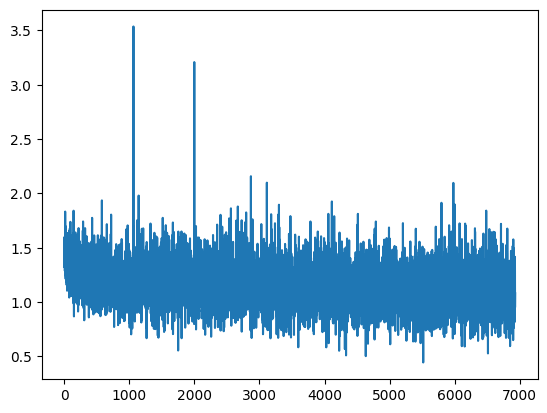

In [23]:
plt.plot(train_losses)

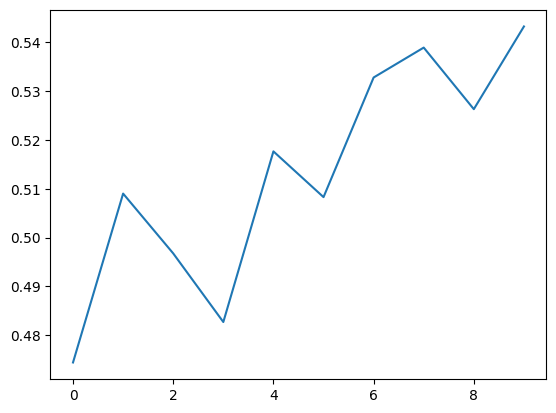

In [24]:
plt.plot(test_accuracy)

In [25]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [26]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 1507/2768 (0.5444)
{'acc_detail': tensor([0.4377, 0.7009, 0.5377, 0.4780], device='cuda:0'),
 'acc_unweighted': tensor(0.5386, device='cuda:0'),
 'acc_weighted': tensor(0.5444, device='cuda:0'),
 'f1s_detail': tensor([0.5004, 0.6212, 0.5149, 0.5070], device='cuda:0'),
 'f1s_unweighted': tensor(0.5359, device='cuda:0'),
 'f1s_weighted': tensor(0.5400, device='cuda:0'),
 'precision_detail': tensor([0.5842, 0.5578, 0.4939, 0.5397], device='cuda:0'),
 'recall_detail': tensor([0.4377, 0.7009, 0.5377, 0.4780], device='cuda:0'),
 'rocauc': tensor(0.7887, device='cuda:0'),
 'rocauc_detail': tensor([0.7848, 0.8161, 0.8064, 0.7475], device='cuda:0'),
 'uar': tensor(0.5386, device='cuda:0'),
 'wap': tensor(0.5465, device='cuda:0')}


tensor([[281,  81, 126, 154],
        [ 40, 560,  82, 117],
        [ 71, 120, 285,  54],
        [ 89, 243,  84, 381]], device='cuda:0')

In [27]:
model_path = '../models_msp4/msp4_m13mfcc_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [28]:
model.to('cpu')

M13mfcc(
  (mfcc): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=40, out_features=512, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [29]:
!nvidia-smi

Fri Mar  1 10:28:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   35C    P2              44W / 215W |    886MiB /  8192MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--